# Outlier Detection with Autoencoders

In [1]:
import os
from datetime import datetime
from typing import Dict, List, Tuple
import warnings

import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms

C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Creating and Preprocessing the Data

### Loading the data

In [2]:
cardio_dict = scipy.io.loadmat('cardio.mat')

In [3]:
cardio_dict

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
         -0.28978574, -0.49329397],
        [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
         -0.25638541, -0.49329397],
        [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
         -0.25638541,  1.14001753],
        ...,
        [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
          0.24461959, -0.49329397],
        [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
          0.14441859, -0.49329397],
        [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
          3.58465295, -0.49329397]]),
 'y': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [4]:
X = cardio_dict['X']
y = cardio_dict['y'].flatten()

In [5]:
INPUT_SIZE = X.shape[1]
print(f'Size of input example: {INPUT_SIZE}')

Size of input example: 21


### Data splitting

Divide the dataset into inliers and outliers:
- only inliers are used for trainig the autoencoders
- outliers are then mixed with the test set

In [6]:
X_inliers = X[y==0]
y_inliers = np.zeros(len(X_inliers), dtype=int)
X_outliers = X[y==1]
y_outliers = np.ones(len(X_outliers), dtype=int)
print(f'Number of inliers: {len(y_inliers)}, Number of outliers: {len(y_outliers)}')

Number of inliers: 1655, Number of outliers: 176


Split the inliers into training, validation, and testing set:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_inliers, y_inliers, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.2 x 0.8 = 0.16

Add outliers only to the test set

In [8]:
X_test = np.concatenate((X_test, X_outliers), axis=0)
y_test = np.concatenate((y_test, y_outliers), axis=0)

In [9]:
print(f'Training set: {len(y_train)} examples')
print(f'Validation set: {len(y_val)} examples')
print(f'Testing set: {len(y_test)} examples; inliers: {np.sum(y_test==0)}, outliers: {np.sum(y_test==1)}')

Training set: 1059 examples
Validation set: 265 examples
Testing set: 507 examples; inliers: 331, outliers: 176


In [10]:
display(X_train.shape)

(1059, 21)

### Creating Dataset and DataLoader instances

In [11]:
class CardioDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.int32]:
        return self.data[idx], self.labels[idx]

In [12]:
train_data = CardioDataset(X_train, y_train)
val_data = CardioDataset(X_val, y_val)

In [13]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

## Autoencoder Models

### 1. Undercomplete AutoEncoder

In [47]:
HIDDEN_SIZE_UAE = 16
LATENT_SIZE_UAE = 14

In [48]:
class UndercompleteAutoEncoder(nn.Module):
    def __init__(self):
        super(UndercompleteAutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE_UAE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE_UAE, LATENT_SIZE_UAE),
        )
        self.decode = nn.Sequential(
            nn.Linear(LATENT_SIZE_UAE, HIDDEN_SIZE_UAE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE_UAE, INPUT_SIZE),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encode(x)
        x = self.decode(x)
        return x

In [49]:
undercomplete_ae = UndercompleteAutoEncoder()

learning_rate_uae = 1e-2
optimizer_uae = torch.optim.Adam(undercomplete_ae.parameters(), lr=learning_rate_uae)
criterion_uae = nn.MSELoss()

In [50]:
def train_one_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss):
    '''
    Train one epoch of the model on training dataset batched by the train_dataloader.
    
    :param nn.Module model: model on which we perform one training epoch
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs.float(), inputs.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_dataloader)

In [51]:
def train_model(model: nn.Module, model_name: str, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss, nr_of_epochs: int = 100):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param int nr_of_epochs: number of training epochs
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch(model, optimizer, criterion)
        model.eval()

        # performance on validation set
        valid_loss = 0.0
        for i, data in enumerate(val_dataloader):
            inputs, _ = data
            outputs = model(inputs.float())
            loss = criterion(outputs.float(), inputs.float())
            valid_loss += loss.item()
        valid_loss = valid_loss / len(val_dataloader)

        # logging at each Nth epoch
        if (epoch + 1) % 10 == 0:
            print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')
        
        # remember model with the best validation loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1

    # save the overall best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('models/', exist_ok=True)
    model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
    torch.save(best_model, model_path)

In [52]:
train_model(model=undercomplete_ae, model_name='undercomplete_autoencoder', optimizer=optimizer_uae, criterion=criterion_uae, nr_of_epochs=200)

epoch 10; train loss: 0.11725766255575068; valid loss: 0.09497415125370026
epoch 20; train loss: 0.050852848545593375; valid loss: 0.04040834382176399
epoch 30; train loss: 0.033241695231374574; valid loss: 0.02810182999819517
epoch 40; train loss: 0.027355168781736317; valid loss: 0.021982203982770444
epoch 50; train loss: 0.018912932397249865; valid loss: 0.01675143577158451
epoch 60; train loss: 0.013609825249980478; valid loss: 0.014086961932480335
epoch 70; train loss: 0.012940240969114444; valid loss: 0.013934897817671299
epoch 80; train loss: 0.012910615543232244; valid loss: 0.013759488333016634
epoch 90; train loss: 0.013030299095108229; valid loss: 0.01403334978967905
epoch 100; train loss: 0.012672463925007512; valid loss: 0.013779087830334902
epoch 110; train loss: 0.012645743842072347; valid loss: 0.013554778508841991
epoch 120; train loss: 0.012718429241110297; valid loss: 0.013656550832092763
epoch 130; train loss: 0.013122758608968818; valid loss: 0.014112475607544184
e

In [53]:
def eval_on_testset(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.sum((reconstructed_test.detach() - testset_tensor) ** 2, axis=1)
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    display(error_df[error_df['class'] == 0].describe())
    display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [54]:
test_df, test_MSEs = eval_on_testset(undercomplete_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.924453,0.0
std,11.018229,0.0
min,0.014906,0.0
25%,0.083508,0.0
50%,0.152681,0.0
75%,0.291427,0.0
max,200.517059,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,15.251942,1.0
std,64.590340,0.0
min,0.046266,1.0
25%,0.560311,1.0
50%,1.410423,1.0
75%,3.427566,1.0
max,489.311584,1.0


In [55]:
def classify_by_error(MSEs: np.ndarray, thres: float) -> np.ndarray:
    '''
    Classify an array of reconstruction errors w.r.t. a threshold
    
    :param np.ndarray MSEs: mean squared reconstruction errors
    :param float thres: threshold of reconstruction error between inliers and outliers
    :returns: binary array of class ids; 0 = inlier, 1 = outlier
    '''
    return np.array(MSEs > thres, dtype=int)

In [56]:
def plot_confusion_matrix(confusion_mat: np.ndarray):
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray confusion_mat: confusion matrix between true and predicted labels
    '''
    class_labels = ['Inlier', 'Outlier']
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt="d", annot_kws={"size": 14});
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [57]:
def try_threshold_grid(MSEs: np.ndarray, true_labels: np.ndarray, model_name: str, start: float = 0.0, stop: float = 5.0, num_thresholds: int = 10, verbose: bool = True) -> float:
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray MSEs: mean squared reconstruction errors on testing set
    :param np.ndarray true_labels: ground-truth labels
    :param str model_name: model name, e.g. denoising_autoencoder
    :param float start: start of threshold interval
    :param float stop: end of threshold interval
    :param int num_thresholds: number of thresholds tested in the interval
    :returns: threshold with the highest anomaly f1-score
    '''
    best_threshold = None
    best_f1 = 0.0
    display(Markdown(f'### Model: {model_name}, trying {num_thresholds} thresholds from [{start}, {stop}]'))
    if not verbose:
        display(Markdown('For more detail, call the method with `verbose=True`'))
        
    for threshold in np.linspace(start, stop, num=num_thresholds):
        predictions = classify_by_error(MSEs, threshold)
        matrix = confusion_matrix(true_labels, predictions)
        class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
        acc_df = pd.DataFrame({
            'Inliers Accuracy': [class_accuracies[0]], 
            'Outliers Accuracy': [class_accuracies[1]], 
            'Overall Accuracy': [accuracy_score(true_labels, predictions)]
        })
        
        outlier_f1 = f1_score(true_labels, predictions)
        if outlier_f1 > best_f1:
            best_f1 = outlier_f1
            best_threshold = threshold
        
        if verbose:
            display(Markdown(f'### Threshold {threshold}'))
            display(acc_df.style.hide_index())
            display(Markdown(f'##### Classification Report'))
            print(classification_report(true_labels, predictions))
            # plot_confusion_matrix(matrix)
            display(Markdown('---'))
    
    return best_threshold

In [58]:
optimal_threshold_under = try_threshold_grid(test_MSEs, y_test, 'undercomplete_autoencoder', start=0.1, stop=2.0, num_thresholds=40, verbose=False)

### Model: undercomplete_autoencoder, trying 40 thresholds from [0.1, 2.0]

For more detail, call the method with `verbose=True`

### Best Threshold 0.39230769230769236

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.824773,0.863636,0.838264


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       331
           1       0.72      0.86      0.79       176

    accuracy                           0.84       507
   macro avg       0.82      0.84      0.83       507
weighted avg       0.85      0.84      0.84       507



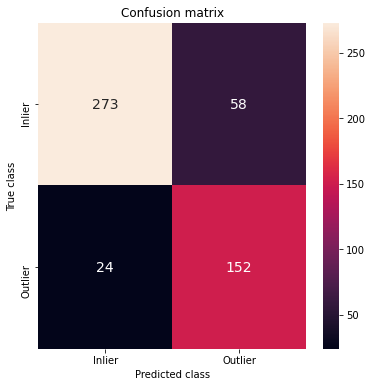

In [59]:
predictions = classify_by_error(test_MSEs, optimal_threshold_under)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Best Threshold {optimal_threshold_under}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

### 2. Denoising AutoEncoder

In [61]:
HIDDEN_SIZE_DAE = 16
LATENT_SIZE_DAE = 14

In [62]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, noise_rate):
        super(DenoisingAutoEncoder, self).__init__()
        self.noise_rate = noise_rate
        self.encode = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE_DAE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE_DAE, LATENT_SIZE_DAE),
        )
        self.decode = nn.Sequential(
            nn.Linear(LATENT_SIZE_DAE, HIDDEN_SIZE_DAE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE_DAE, INPUT_SIZE),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            # randn_like returns tensor the same shape as x with random numbers
            # from a normal distribution with mean 0 and variance 1
            x = x + torch.randn_like(x) * self.noise_rate
        x = self.encode(x)
        x = self.decode(x)
        return x

In [63]:
denoising_ae = DenoisingAutoEncoder(noise_rate=0.1)

learning_rate_dae = 1e-2
optimizer_dae = torch.optim.Adam(denoising_ae.parameters(), lr=learning_rate_dae)
criterion_dae = nn.MSELoss()

In [64]:
train_model(model=denoising_ae, model_name='denoising_autoencoder', optimizer=optimizer_dae, criterion=criterion_dae, nr_of_epochs=200)

epoch 10; train loss: 0.1108793029013802; valid loss: 0.08984012752771378
epoch 20; train loss: 0.059835894362014884; valid loss: 0.04084300212562084
epoch 30; train loss: 0.042641625465715635; valid loss: 0.03133524004369974
epoch 40; train loss: 0.03399840895743931; valid loss: 0.024208145029842854
epoch 50; train loss: 0.031179090194842395; valid loss: 0.02024469170719385
epoch 60; train loss: 0.02948989697238978; valid loss: 0.021036148257553577
epoch 70; train loss: 0.028388573404620674; valid loss: 0.01859047245234251
epoch 80; train loss: 0.028102723881602287; valid loss: 0.01956101320683956
epoch 90; train loss: 0.027784872361842322; valid loss: 0.0184914942830801
epoch 100; train loss: 0.026660294107654515; valid loss: 0.018377898260951042
epoch 110; train loss: 0.02348597807919278; valid loss: 0.014939586073160172
epoch 120; train loss: 0.020605995045865282; valid loss: 0.014835073240101337
epoch 130; train loss: 0.019879463731366044; valid loss: 0.015170551277697087
epoch 14

In [65]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.876662,0.0
std,9.982570,0.0
min,0.052648,0.0
25%,0.115039,0.0
50%,0.165183,0.0
75%,0.276604,0.0
max,181.644226,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,13.686307,1.0
std,53.015030,0.0
min,0.165945,1.0
25%,0.375754,1.0
50%,1.417939,1.0
75%,3.814936,1.0
max,407.051239,1.0


In [66]:
optimal_threshold_denoising = try_threshold_grid(test_MSEs, y_test, 'denoising_autoencoder', start=0.1, stop=2.0, num_thresholds=40, verbose=False)

### Model: denoising_autoencoder, trying 40 thresholds from [0.1, 2.0]

For more detail, call the method with `verbose=True`

### Best Threshold 0.2948717948717949

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.773414,0.840909,0.796844


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       331
           1       0.66      0.84      0.74       176

    accuracy                           0.80       507
   macro avg       0.78      0.81      0.79       507
weighted avg       0.82      0.80      0.80       507



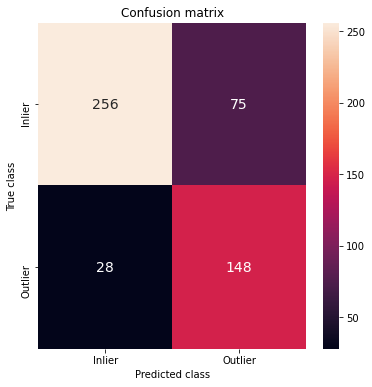

In [67]:
predictions = classify_by_error(test_MSEs, optimal_threshold_denoising)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Best Threshold {optimal_threshold_denoising}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

### 3. Variational AutoEncoder

In [68]:
HIDDEN_SIZE_VAE = 16
LATENT_SIZE_VAE = 14

In [69]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encLin1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE_VAE)
        self.reluEnc = nn.ReLU()
        self.encLin21 = nn.Linear(HIDDEN_SIZE_VAE, LATENT_SIZE_VAE)
        self.encLin22 = nn.Linear(HIDDEN_SIZE_VAE, LATENT_SIZE_VAE)
        self.normal = torch.distributions.Normal(0, 1)
        self.kl = 0
        
        self.decLin1 = nn.Linear(LATENT_SIZE_VAE, HIDDEN_SIZE_VAE)
        self.reluDec = nn.ReLU()
        self.decLin2 = nn.Linear(HIDDEN_SIZE_VAE, INPUT_SIZE)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.reluEnc(self.encLin1(x))
        mu = self.encLin21(x)
        sigma = torch.exp(self.encLin22(x))
        z = mu + sigma * self.normal.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()

        x = self.reluDec(self.decLin1(z))
        x = self.decLin2(x)
        return x

In [70]:
variational_ae = VariationalAutoEncoder()

learning_rate_vae = 1e-2
optimizer_vae = torch.optim.Adam(variational_ae.parameters(), lr=learning_rate_vae)
criterion_vae = nn.MSELoss()

In [71]:
def train_one_epoch_VAE(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss):
    '''
    Train one epoch of the model on training dataset batched by the train_dataloader.
    
    :param nn.Module model: model on which we perform one training epoch
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_dataloader)

In [72]:
def train_model_VAE(model: nn.Module, model_name: str, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss, nr_of_epochs: int = 100):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param int nr_of_epochs: number of training epochs
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch_VAE(model, optimizer, criterion)
        model.eval()

        # performance on validation set
        with torch.no_grad():
            valid_loss = 0.0
            for i, data in enumerate(val_dataloader):
                inputs, _ = data
                outputs = model(inputs.float())
                loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
                valid_loss += loss.item()
            valid_loss = valid_loss / len(val_dataloader)

            # logging at each Nth epoch
            if (epoch + 1) % 10 == 0:
                print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')

            # remember model with the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = model.state_dict()
                best_epoch = epoch + 1

    # save the overall best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('models/', exist_ok=True)
    model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
    torch.save(best_model, model_path)

In [73]:
train_model_VAE(model=variational_ae, model_name='variational_autoencoder', optimizer=optimizer_vae, criterion=criterion_vae, nr_of_epochs=200)

epoch 10; train loss: 0.9785542102421031; valid loss: 0.973831057548523
epoch 20; train loss: 0.9455225537804997; valid loss: 0.9254871129989624
epoch 30; train loss: 0.925399173708523; valid loss: 0.914651608467102
epoch 40; train loss: 0.9206251747467938; valid loss: 0.917154335975647
epoch 50; train loss: 0.919940825770883; valid loss: 0.9103542566299438
epoch 60; train loss: 0.9132372526561513; valid loss: 0.9124483227729797
epoch 70; train loss: 0.9161754846572876; valid loss: 0.9309447884559632
epoch 80; train loss: 0.9127960590755239; valid loss: 0.9184232115745544
epoch 90; train loss: 0.9123351188266978; valid loss: 0.9068930625915528
epoch 100; train loss: 0.9127651978941524; valid loss: 0.9099053740501404
epoch 110; train loss: 0.9139322989127215; valid loss: 0.9110538601875305
epoch 120; train loss: 0.909916036269244; valid loss: 0.9045243978500366
epoch 130; train loss: 0.9067581366090214; valid loss: 0.924078643321991
epoch 140; train loss: 0.9118376970291138; valid loss:

In [74]:
def eval_on_testset_VAE(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.mean((reconstructed_test.detach() - testset_tensor) ** 2, axis=1) + model.kl
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    display(error_df[error_df['class'] == 0].describe())
    display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [75]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.876662,0.0
std,9.982570,0.0
min,0.052648,0.0
25%,0.115039,0.0
50%,0.165183,0.0
75%,0.276604,0.0
max,181.644226,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,13.686307,1.0
std,53.015030,0.0
min,0.165945,1.0
25%,0.375754,1.0
50%,1.417939,1.0
75%,3.814936,1.0
max,407.051239,1.0


In [76]:
optimal_threshold_vae = try_threshold_grid(test_MSEs, y_test, 'variational_autoencoder', start=0.1, stop=2.0, num_thresholds=40, verbose=False)

### Model: variational_autoencoder, trying 40 thresholds from [0.1, 2.0]

For more detail, call the method with `verbose=True`

### Best Threshold 0.2948717948717949

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.773414,0.840909,0.796844


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       331
           1       0.66      0.84      0.74       176

    accuracy                           0.80       507
   macro avg       0.78      0.81      0.79       507
weighted avg       0.82      0.80      0.80       507



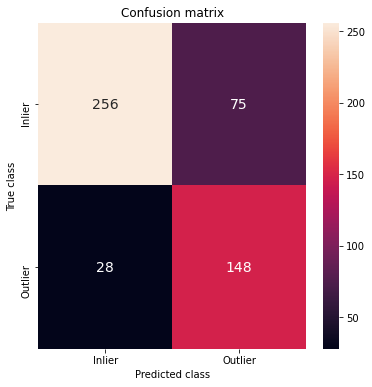

In [77]:
predictions = classify_by_error(test_MSEs, optimal_threshold_vae)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Best Threshold {optimal_threshold_vae}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

## Final Remarks

I have compared three different autoencoder architectures for outlier detection:
1. undercomplete autoencoder
2. denoising autoencoder
3. variational autoencoder

For each of them, I tuned the following hyperparameters:
- learning rate
- batch size
- number of layers and their width (most importantly the size of the latent space)
- threshold for reconstruction error

I have chosen the best classifier based on the F1-score, where negative class is composed of inliers and positive class is composed of outliers.

Below, you can find the best hyper-parameters of the architectures. As for the layers, only encoder architecture is shown, since decoder contains the same layers reversed.

In [80]:
result_df = pd.DataFrame({'Architecture': ['Undercomplete Autoencoder', 'Denoising Autoencoder', 'Variational Autoencoder'],
                          'Learning Rate': [learning_rate_uae, learning_rate_dae, learning_rate_vae],
                          'Batch Size': [64, 64, 64], 
                          'Architecture Encoder': [
                              f'Linear({INPUT_SIZE}, {HIDDEN_SIZE_UAE}) → ReLU → Linear({HIDDEN_SIZE_UAE}, {LATENT_SIZE_UAE})', f'Linear({INPUT_SIZE}, {HIDDEN_SIZE_DAE}) → ReLU → Linear({HIDDEN_SIZE_DAE}, {LATENT_SIZE_DAE})', f'Linear({INPUT_SIZE}, {HIDDEN_SIZE_VAE}) → ReLU → LinearMu({HIDDEN_SIZE_VAE}, {LATENT_SIZE_VAE}), LinearSigma({HIDDEN_SIZE_VAE}, {LATENT_SIZE_VAE})'
                          ],
                          'Latent Space Size': [14, 14, 14],
                          'Reconstruction MSE Threshold': [optimal_threshold_under, optimal_threshold_denoising, optimal_threshold_vae],
                         })
result_df = result_df.set_index('Architecture')
display(result_df)

,Learning Rate,Batch Size,Architecture Encoder,Latent Space Size,Reconstruction MSE Threshold
Architecture,,,,,
Undercomplete Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.392308
Denoising Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.294872
Variational Autoencoder,0.01,64,"Linear(21, 16) → ReLU → LinearMu(16, 14), Line...",14,0.294872
